In [487]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
plt.rcParams['figure.figsize'] = [20,5]

In [498]:

# helper methods..

def d_type(x):
    types = []
    for xi in x:
        types.append(train[xi].dtype)
    return types

def null_counts(data):
    #return number of missing values and proportion
    missing = data.isnull().sum().sort_values(ascending=False)
    percent = missing/len(data)
    frame = pd.concat([missing,percent],axis=1,keys=['missing','prop'])
    frame['type'] = d_type(list(frame.index))
    
    return frame.reset_index()

def drop_cols(train,test):
    #drop all columns in train set with missing values > 81.
    #drops same columns in test set
    nulls = null_counts(train)
    droplist = list(nulls['index'][nulls.missing > 81])
    train = train.drop(droplist,1)
    test = test.drop(droplist,1)
    
    return train,test

def get_numeric_missing(df):
    #returns list of numeric type column names containnig missing values
    df_nulls = null_counts(df)
    numerics = df_nulls['index'][(df_nulls['missing']>0)&
                                   ((df_nulls['type']=='float64')| (df_nulls['type']=='int64'))].to_list()
    return numerics

def get_cats_missing(df):
    #returns list of object type columns containing missing values
    df_nulls = null_counts(df)
    cats = df_nulls['index'][(df_nulls['missing']>0) & (df_nulls['type'] == 'object')].to_list()
    
    return cats

def fill_nulls(train,test):
    #nulls for these columns means the item does not exist.
    nonexistant = ['GarageType','GarageFinish','GarageCond','GarageQual',
            'BsmtExposure','BsmtFinType2','BsmtFinType1','BsmtCond','BsmtQual']
    
    train[nonexistant]=train[nonexistant].fillna('nil')
    test[nonexistant]=test[nonexistant].fillna('nil')

    numeric_train = get_numeric_missing(train)
    cats_train = get_cats_missing(train)
    
    train[numeric_train] = train[numeric_train].fillna(train[numeric_train].apply(np.mean))
    train[cats_train] = train[cats_train].fillna(train[cats_train].mode().iloc[0,:])
    
    
    numeric_test = get_numeric_missing(test)
    cats_test = get_cats_missing(test)
    
    test[cats_test] = test[cats_test].fillna(train[cats_test].mode().iloc[0,:])
    test[numeric_test] = test[numeric_test].fillna(test[numeric_test].apply(np.mean))
    
    train['MoSold'] = train['MoSold'].astype('object')
    test['MoSold'] = test['MoSold'].astype('object')
    train = train.drop(['Id'],1)
    
    return train,test



In [353]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
#a 50-50 train test split

print('rows in test: ',len(train))
print('rows in train: ',len(test))

rows in test:  1460
rows in train:  1459


null values in the columns 'GarageType','GarageFinish','GarageCond','GarageQual','BsmtExposure','BsmtFinType2','BsmtFinType1','BsmtCond','BsmtQual'  mean that those features do not exist on the property. They are filled in with 'nil' to indicate a new category.

All other missing categorical values are filled with the mode of that column
All missing numeric values are filled with the mean.

In [354]:
train,test = drop_cols(train,test)
train,test = fill_nulls(train,test)


In [355]:
train.select_dtypes('object').columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'MoSold', 'SaleType', 'SaleCondition'],
      dtype='object')

<Figure size 1440x360 with 0 Axes>

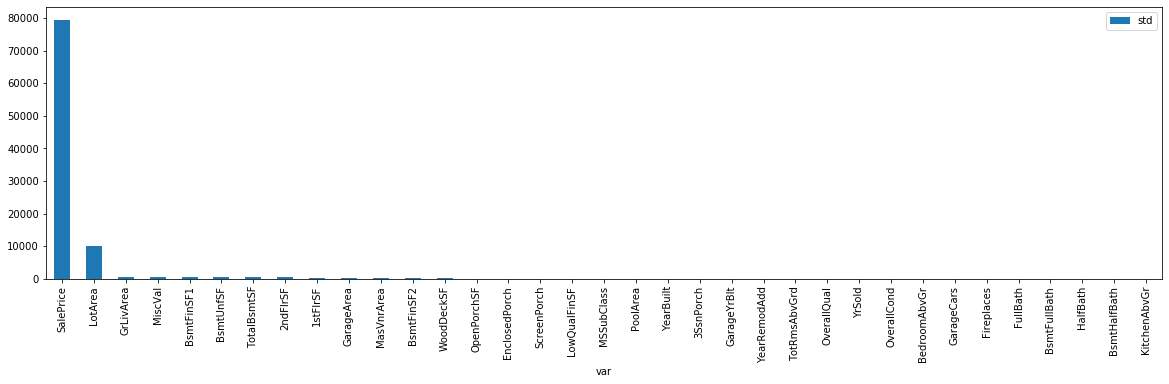

<Figure size 1440x360 with 0 Axes>

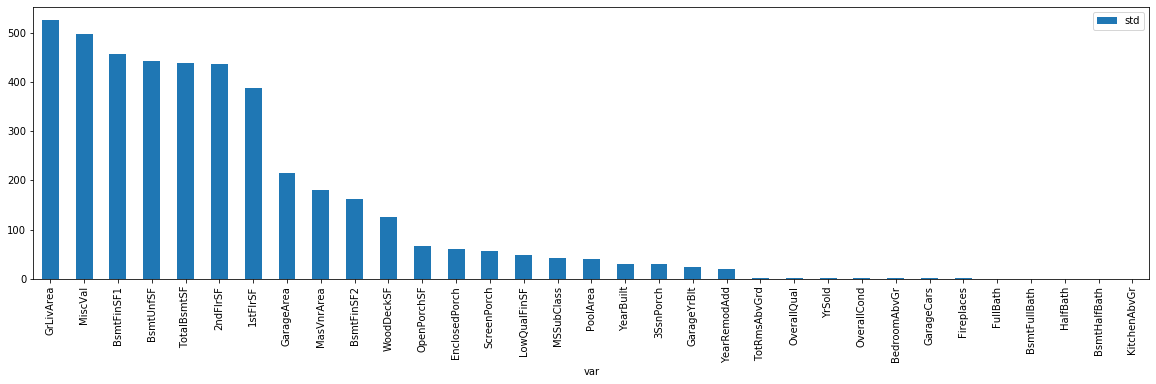

<Figure size 1440x360 with 0 Axes>

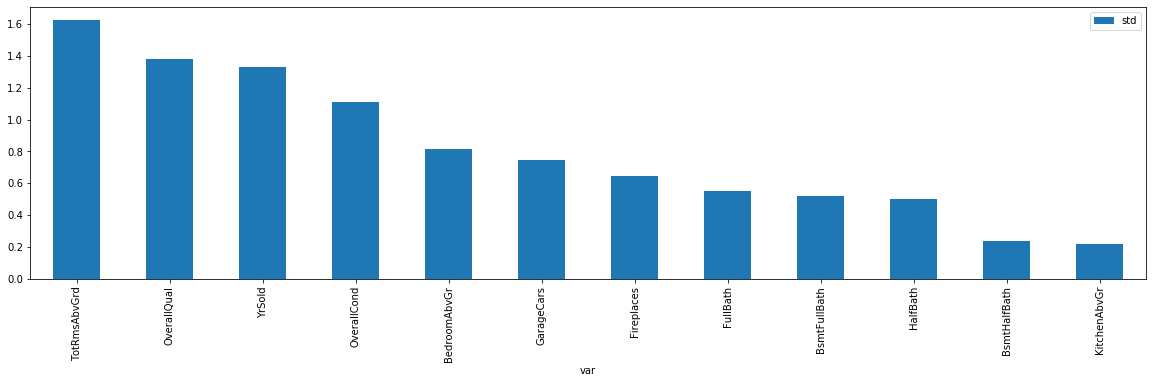

In [488]:
numeric_cols = train.select_dtypes(np.number).columns.to_list()
std = pd.DataFrame(train[numeric_cols]).std().reset_index()
std.columns = ['var','std']
plt.figure(figsize = (20,5))
std.sort_values(by='std',ascending=False).iloc[0:,:].plot.bar(x='var',y='std');
plt.figure(figsize = (20,5))
std.sort_values(by='std',ascending=False).iloc[2:,:].plot.bar(x='var',y='std');
plt.figure(figsize = (20,5))
std.sort_values(by='std',ascending=False).iloc[23:,:].plot.bar(x='var',y='std');

<Figure size 720x360 with 0 Axes>

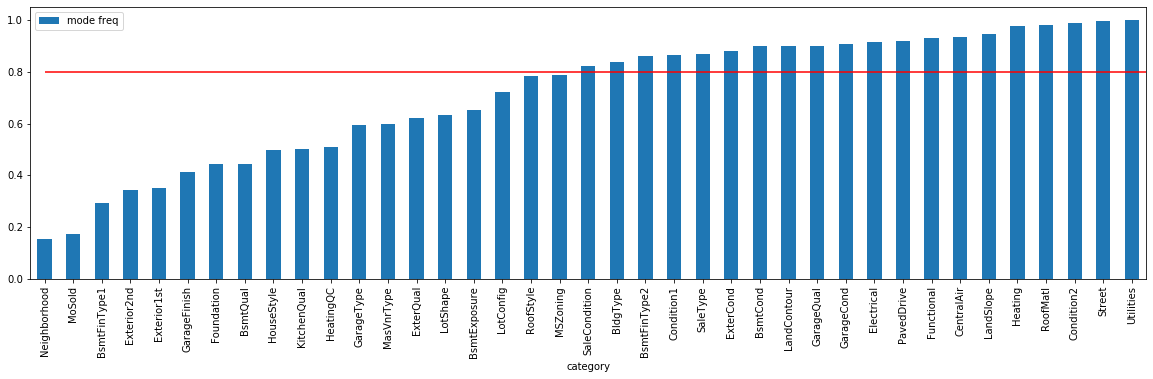

In [497]:
def get_cat(df): 
    return df.select_dtypes('object').columns.to_list()
def get_num(df):
    return df.select_dtypes(np.number).columns.to_list()
def encode_cats(df):
    le = encoder()
    cols = df.select_dtypes('object').columns.to_list()
    for colname in cols:
        df[colname] = le.fit_transform(df[colname])
    return cols, df

def category_frequencies(df):
    #returns the frequency of the mode in each categorical feature
    cats = get_cat(df)
    cat_freq = []
    for cat in cats:
        mode_freq = df.loc[:,cat].value_counts().max()/len(df)
        cat_freq.append([cat,mode_freq])
        
    return pd.DataFrame(cat_freq, columns = ['category','mode freq'])

df = category_frequencies(train).sort_values(by='mode freq',ascending=True)

plt.figure(figsize = (10,5))
#chart = sns.barplot(data=df,x='category',y='mode freq')
#chart.set_xticklabels(chart.get_xticklabels(),rotation=45)
#chart;
df.plot.bar(x='category')
plt.hlines(y=0.8,xmin=0,xmax=40,colors='red');

In [372]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder as encoder

In [384]:
y = train['SalePrice']
X = train.drop(['SalePrice'],axis=1)
cats = X.select_dtypes('object').columns.to_list()

cols, encoded = encode_cats(X)

In [387]:
clf = DecisionTreeRegressor()
clf.fit(encoded,y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

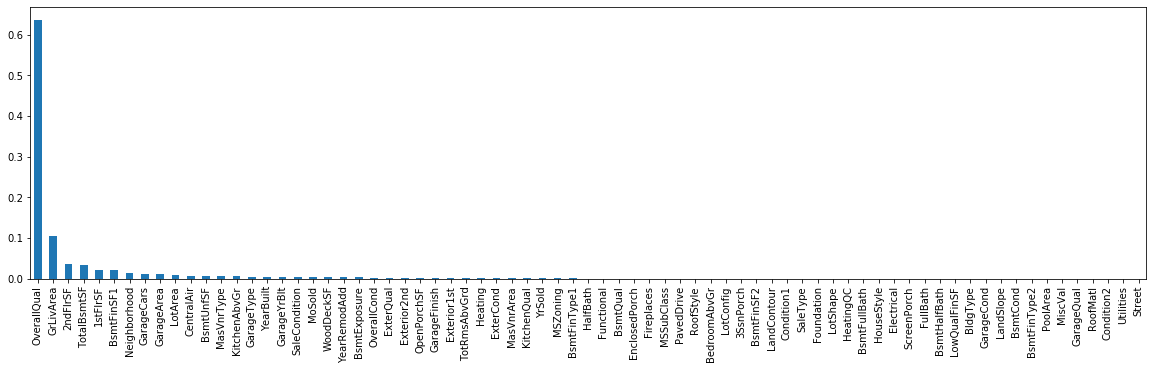

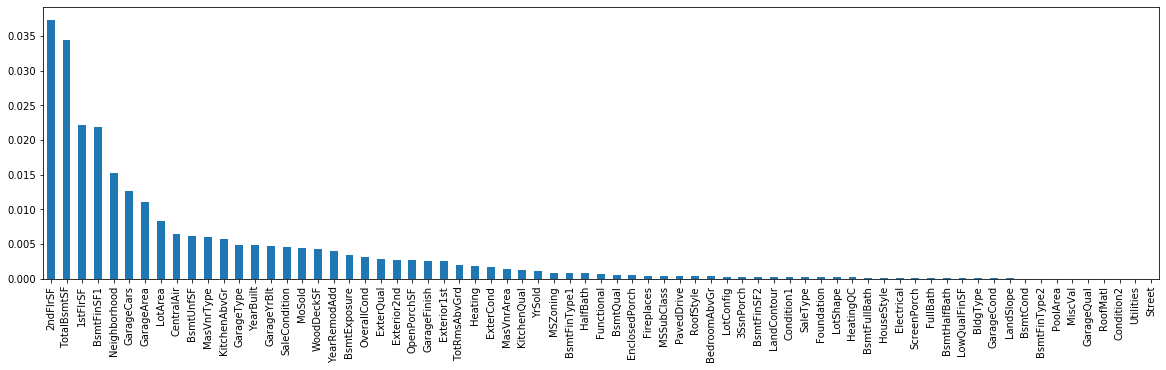

In [413]:
#plot feature importances
plt.figure(figsize = (20,5))
varimp = pd.Series(clf.feature_importances_,index=X.columns)
varimp.sort_values(ascending = False)[0:].plot.bar()
plt.figure(figsize = (20,5))
varimp.sort_values(ascending = False)[2:].plot.bar()

In [517]:
def std_filter(df,threshold):
     return df.std()[df.std()>2].index.to_list()
    
std_filter(train,2)

['MSSubClass',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageYrBlt',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'SalePrice']